# Objaverse++ Parquet Analysis
Download and analyze the Objaverse++ dataset parquet file with visualizations for all available keys.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Download Parquet File

In [2]:
# Get the parquet URLs
response = requests.get("https://huggingface.co/api/datasets/cindyxl/ObjaversePlusPlus/parquet/default/train")
parquet_urls = response.json()

print(f"Found {len(parquet_urls)} parquet files")

# Download the first parquet file if not already downloaded
parquet_file = '0.parquet'
if not Path(parquet_file).exists():
    url = parquet_urls[0]
    print(f"Downloading {parquet_file}...")
    r = requests.get(url, stream=True)
    with open(parquet_file, 'wb') as f:
        f.write(r.content)
    print(f"Downloaded: {parquet_file}")
else:
    print(f"{parquet_file} already exists")

Found 1 parquet files
0.parquet already exists


## Load and Explore Data

In [3]:
# Load the parquet file
df = pd.read_parquet(parquet_file)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (789195, 9)

Columns: ['UID', 'style', 'score', 'is_multi_object', 'is_scene', 'is_figure', 'is_transparent', 'is_single_color', 'density']

First few rows:


,UID,style,score,is_multi_object,is_scene,is_figure,is_transparent,is_single_color,density
0,000074a334c541878360457c672b6c2e,realistic,3,false,false,false,false,false,low
1,0000d20857dd4651a0bd73a62d6fe155,scanned,2,false,true,false,false,false,high
2,0001c4ddd54a4a9a8afe5e03ed0bd082,other,1,false,false,false,false,true,mid
3,000259fe35324ba796ce6e08b2961e3e,other,0,false,false,false,false,false,low
4,0002b84b1d344b00a351b78df4bedbe5,realistic,3,false,false,false,false,false,low


## Stacked Bar Chart - Distribution Overview

Combined view of all 8 columns showing percentage distributions

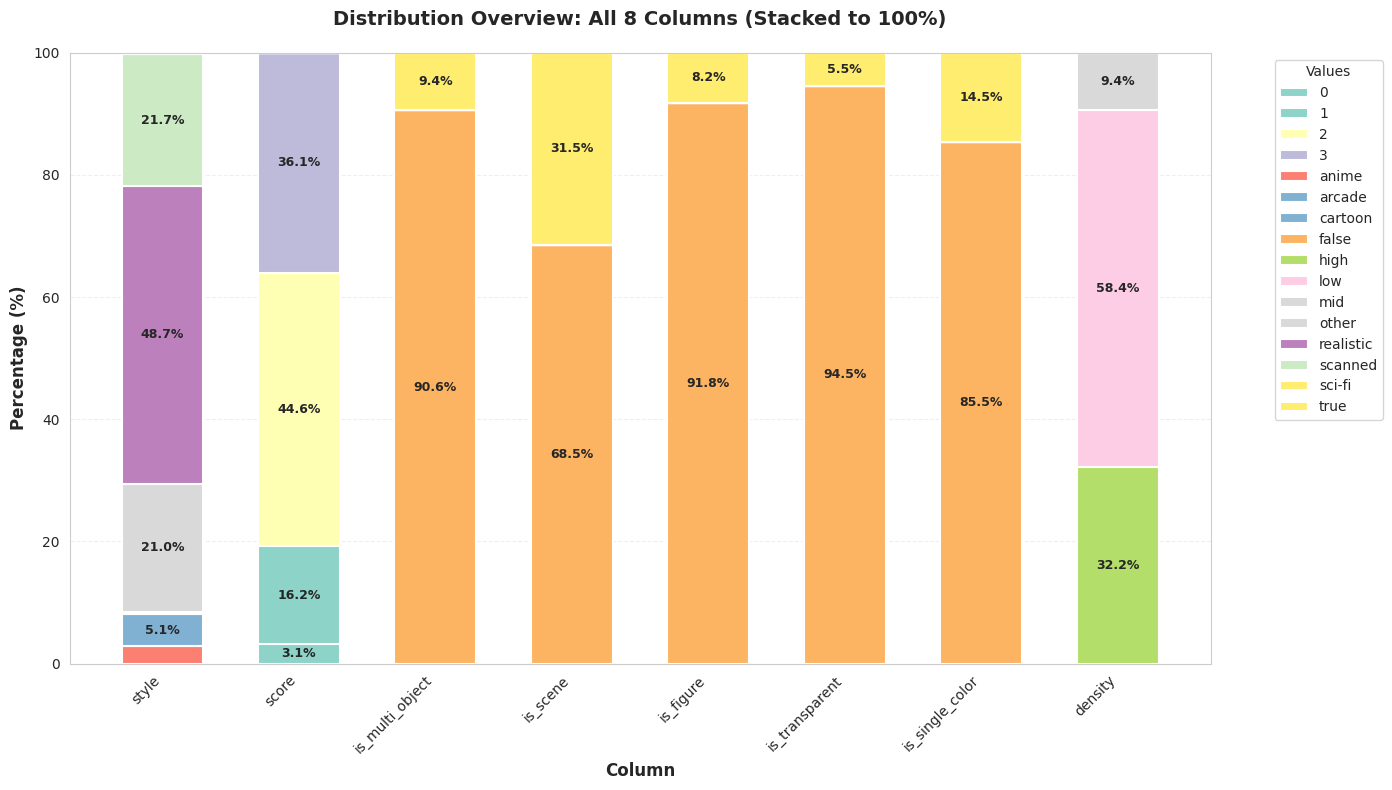


Summary of distributions:

style:
  realistic: 48.66%
  scanned: 21.72%
  other: 20.97%
  arcade: 5.11%
  anime: 2.92%
  cartoon: 0.46%
  sci-fi: 0.16%

score:
  2: 44.63%
  3: 36.07%
  1: 16.18%
  0: 3.13%

is_multi_object:
  false: 90.55%
  true: 9.45%

is_scene:
  false: 68.51%
  true: 31.49%

is_figure:
  false: 91.83%
  true: 8.17%

is_transparent:
  false: 94.52%
  true: 5.48%

is_single_color:
  false: 85.46%
  true: 14.54%

density:
  low: 58.41%
  high: 32.21%
  mid: 9.38%


In [14]:
# Define the 8 columns to visualize
columns_to_plot = ['style', 'score', 'is_multi_object', 'is_scene', 
                   'is_figure', 'is_transparent', 'is_single_color', 'density']

# Calculate percentage distributions for each column
distributions = {}
for col in columns_to_plot:
    if col in df.columns:
        value_counts = df[col].value_counts()
        percentages = (value_counts / len(df) * 100).to_dict()
        distributions[col] = percentages
    else:
        print(f"Warning: Column '{col}' not found in dataset")

# Prepare data for stacked bar chart
# Get all unique values across all columns
all_values = set()
for dist in distributions.values():
    all_values.update(dist.keys())
all_values = sorted(all_values, key=str)

# Create matrix: rows = unique values, columns = our 8 columns
data_matrix = []
for value in all_values:
    row = []
    for col in columns_to_plot:
        if col in distributions:
            row.append(distributions[col].get(value, 0))
        else:
            row.append(0)
    data_matrix.append(row)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Create stacked bar chart
bar_width = 0.6
x_positions = np.arange(len(columns_to_plot))
bottom = np.zeros(len(columns_to_plot))

# Color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(all_values)))

# Plot each value as a segment
for idx, value in enumerate(all_values):
    percentages = [data_matrix[idx][i] for i in range(len(columns_to_plot))]
    bars = ax.bar(x_positions, percentages, bar_width, bottom=bottom, 
                   label=str(value), color=colors[idx], edgecolor='white', linewidth=1.5)
    
    # Add percentage labels on segments (only if > 3% for readability)
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        if pct > 3:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., bottom[i] + height/2.,
                   f'{pct:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')
    
    bottom += percentages

# Customize plot
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Column', fontsize=12, fontweight='bold')
ax.set_title('Distribution Overview: All 8 Columns (Stacked to 100%)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_positions)
ax.set_xticklabels(columns_to_plot, rotation=45, ha='right')
ax.set_ylim(0, 100)
ax.legend(title='Values', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of distributions:")
for col in columns_to_plot:
    if col in distributions:
        print(f"\n{col}:")
        for value, pct in sorted(distributions[col].items(), key=lambda x: x[1], reverse=True):
            print(f"  {value}: {pct:.2f}%")

## Filter High-Quality Objects

Extract UUIDs matching criteria: highest quality (score 3), single object, realistic, non-scene, not transparent, multicolor, high density

In [16]:
# Filter for highest quality objects
filtered_high_quality = df[
    (df['score'] >= 2) &                      # Highest quality score
    (df['style'] == 'realistic') &            # Realistic style
    (df['is_multi_object'] == 'false') &      # Single object
    (df['is_scene'] == 'false') &             # Not a scene
    (df['is_transparent'] == 'false') &       # Not transparent
    (df['is_single_color'] == 'false') &      # Multicolor
    (df['density'] == 'high')                 # High density
]

# Extract UUIDs
high_quality_uids = filtered_high_quality['UID'].tolist()

print(f"Total objects in dataset: {len(df):,}")
print(f"High-quality filtered objects: {len(filtered_high_quality):,}")
print(f"Percentage of dataset: {len(filtered_high_quality)/len(df)*100:.2f}%")
print(f"\nFilter criteria:")
print(f"  - score: 3 (highest)")
print(f"  - style: realistic")
print(f"  - is_multi_object: false")
print(f"  - is_scene: false")
print(f"  - is_transparent: false")
print(f"  - is_single_color: false (multicolor)")
print(f"  - density: high")

print (len(high_quality_uids))

Total objects in dataset: 789,195
High-quality filtered objects: 35,486
Percentage of dataset: 4.50%

Filter criteria:
  - score: 3 (highest)
  - style: realistic
  - is_multi_object: false
  - is_scene: false
  - is_transparent: false
  - is_single_color: false (multicolor)
  - density: high
35486


In [17]:
# Save high-quality UIDs to a text file
output_file = 'high_quality_uids.txt'

with open(output_file, 'w') as f:
    for uid in high_quality_uids:
        f.write(f"{uid}\n")

print(f"Saved {len(high_quality_uids):,} UIDs to '{output_file}'")

Saved 35,486 UIDs to 'high_quality_uids.txt'
